### Résulats

#### Partie 5 - Analyse des résultats et vérification du model


In [3]:
%matplotlib inline

import random
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from IPython.display import display
import tensorflow as tf
from keras.models import load_model
from keras.metrics import MeanIoU
tf.debugging.set_log_device_placement(False)
tf.get_logger().setLevel('WARNING')
tf.autograph.set_verbosity(1)

sys.path.append('..')
import Modules.utils as utils
import Modules.init as init
import Modules.display as disp
import Modules.generator as gen
import Modules.model as model

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

datasets_dir = init.init('U-NET analysis')

<br>**Projet M1 - Détection d'anomalies sur imagerie médicale - U-NET analysis**

Version              : 2
Notebook id          : U-NET analysis
Run time             : Thursday 16 February 2023, 10:21:38
Hostname             : ludovic-ubu (Linux)
Tensorflow log level : Error only  (=2)
Datasets dir         : /media/ludovic/Cache/ENID
Run dir              : ./run
Update keras cache   : False
tensorflow           : 2.11.0
tensorflow.keras     : 2.11.0
numpy                : 1.23.5
skimage              : 0.19.3
matplotlib           : 3.6.2
pandas               : 1.5.2


In [4]:
seed=24
batch_size= 20

val_img_path = os.path.join(datasets_dir, 'DATASET', 'Validation', 'Images')
val_mask_path = os.path.join(datasets_dir, 'DATASET', 'Validation', 'Masks')
val_img_gen = gen.Generator(val_img_path, val_mask_path, batch_size, seed)

model = load_model("ENDOMETRIOSIS_UNET_SEG_JAC_FINAL.hdf5", compile=False)

test_image_batch, test_mask_batch = val_img_gen.__next__()

Found 1244 images belonging to 1 classes.
Found 1244 images belonging to 1 classes.


In [31]:
test_image_batch, test_mask_batch = val_img_gen.__next__()
print(test_image_batch[0])

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


(384, 640, 3)
(384, 640, 1)
(1, 384, 640, 3)
1/1 [==============================] - 0s 326ms/step
(1, 384, 640, 1)
(384, 640, 1)


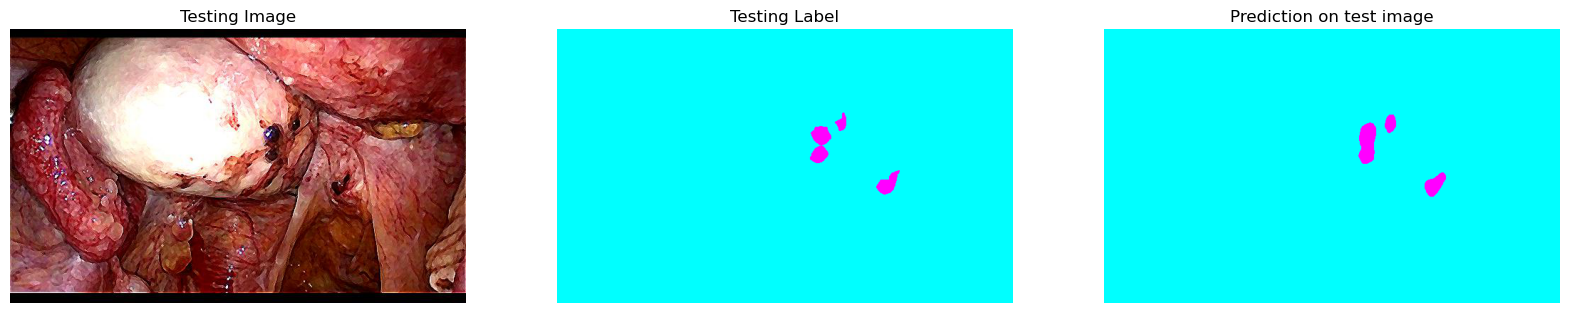

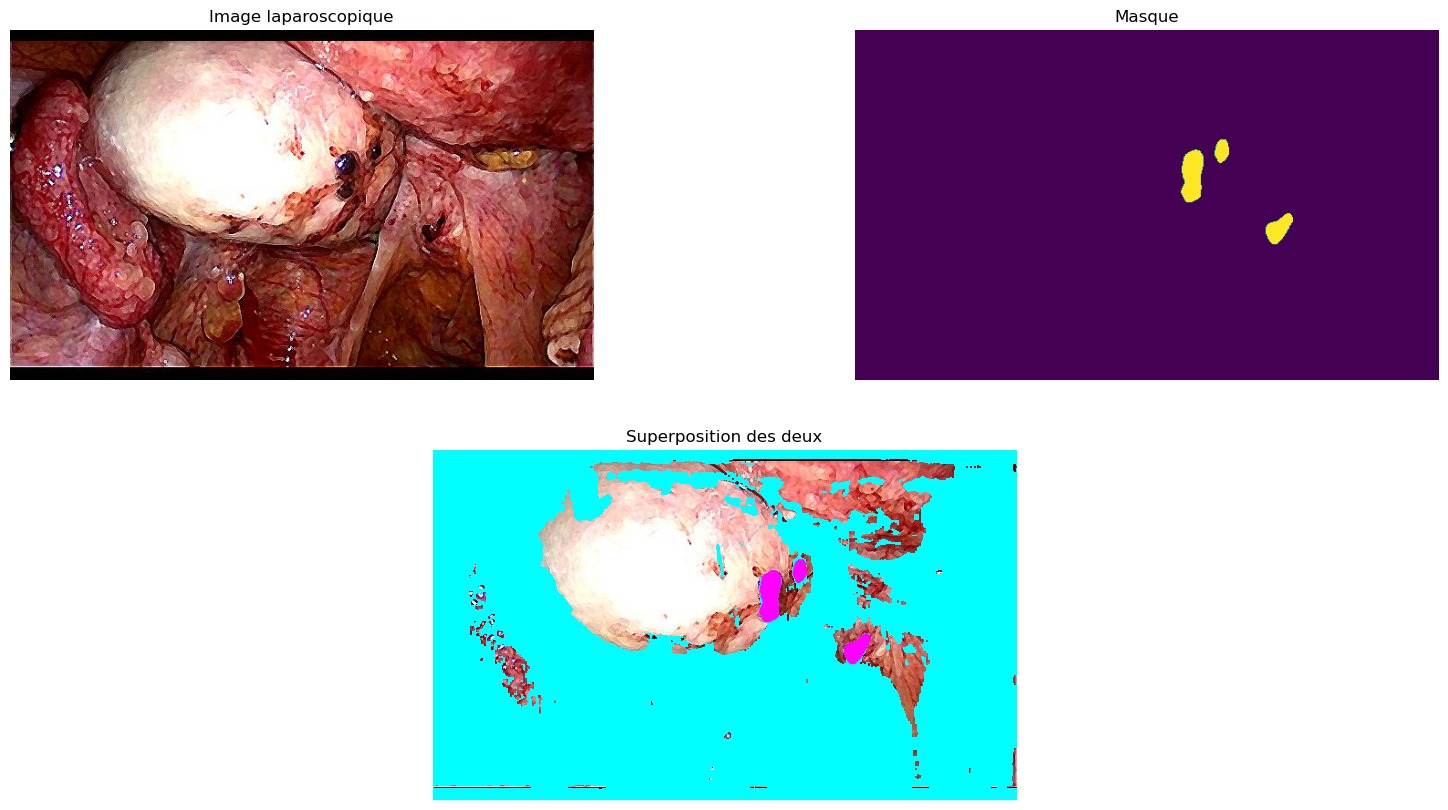

In [25]:
test_image_batch, test_mask_batch = val_img_gen.__next__()
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
print(test_img.shape)
ground_truth=test_mask_batch[test_img_number]
print(ground_truth.shape)

test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input))
print(prediction.shape)
predicted_img=np.reshape(prediction, (384, 640, 1))
print(predicted_img.shape)

plt.figure(figsize=(20, 15))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.axis('off')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='cool')
plt.axis('off')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='cool')
plt.axis('off')
plt.show()

disp.plot3(test_img, predicted_img)

Comme on peut le voir sur l'image ci-dessus, il est necessaire de procéder à une étape de post-processing pour obtenir le masque finale

In [7]:
print("Nombre de valeurs dans le masque après la prédiction : ", len(np.unique(predicted_img)))
print("Valeurs : ", np.unique(predicted_img))

Nombre de valeurs dans le masque après la prédiction :  174485
Valeurs :  [0.0000000e+00 1.1762623e-38 1.1763161e-38 ... 9.9999958e-01 9.9999988e-01
 1.0000000e+00]


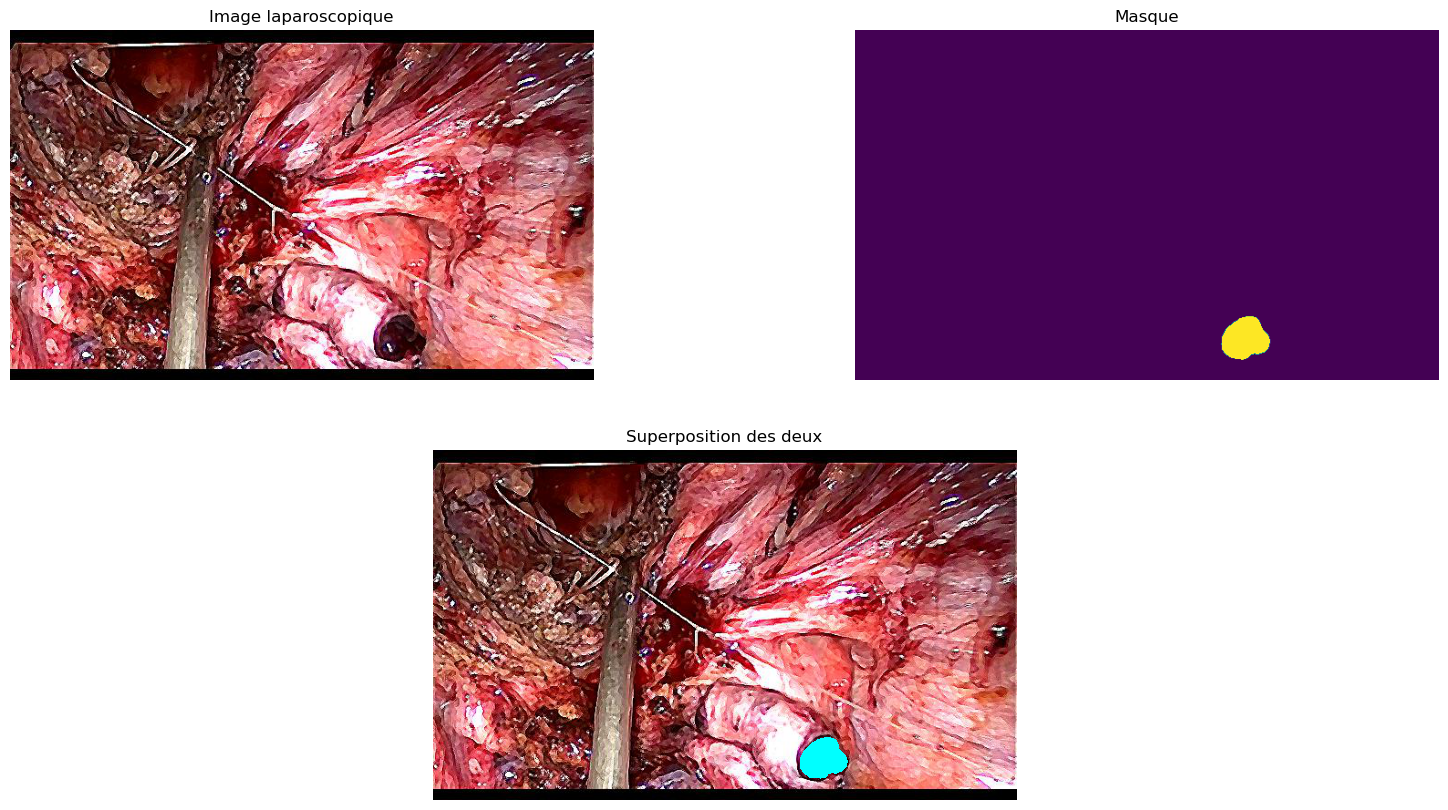

In [8]:
predicted_arr = np.where(predicted_img<0.9, 0, 1)
disp.plot3(test_img, predicted_arr)

In [11]:
IOU_keras = MeanIoU(num_classes=2)  
IOU_keras.update_state(ground_truth, predicted_arr)
print("Mean IoU = ", IOU_keras.result().numpy())

Mean IoU = 0.9357926


Faire un histo du score IOU de chaque images et faire la moyenne en affichant une ligne horiontale dessus !!

Nous allons à présent calculer, pour chaques images du set de validation (set qui n'a jamais été vu par le réseau), la valeur IOU.

In [26]:
histo_iou = []
filelist_img = []
filelist_mask = []

for root, dirs, files in os.walk(val_img_path):
    for file in files:
        filelist_img.append(os.path.join(root, file))

for root, dirs, files in os.walk(val_mask_path):
    for file in files:
        filelist_mask.append(os.path.join(root, file))

1/1 [==============================] - 0s 397ms/step


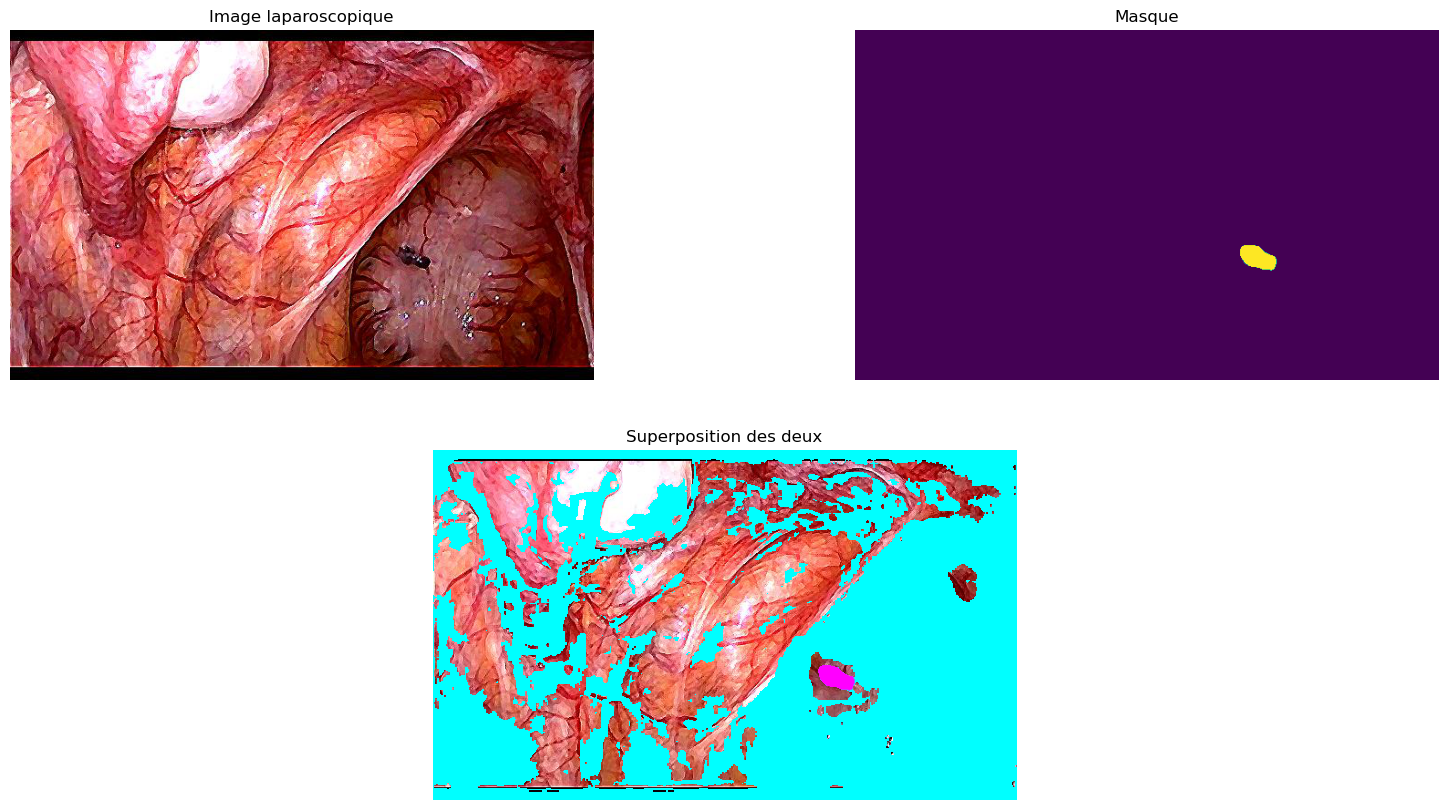

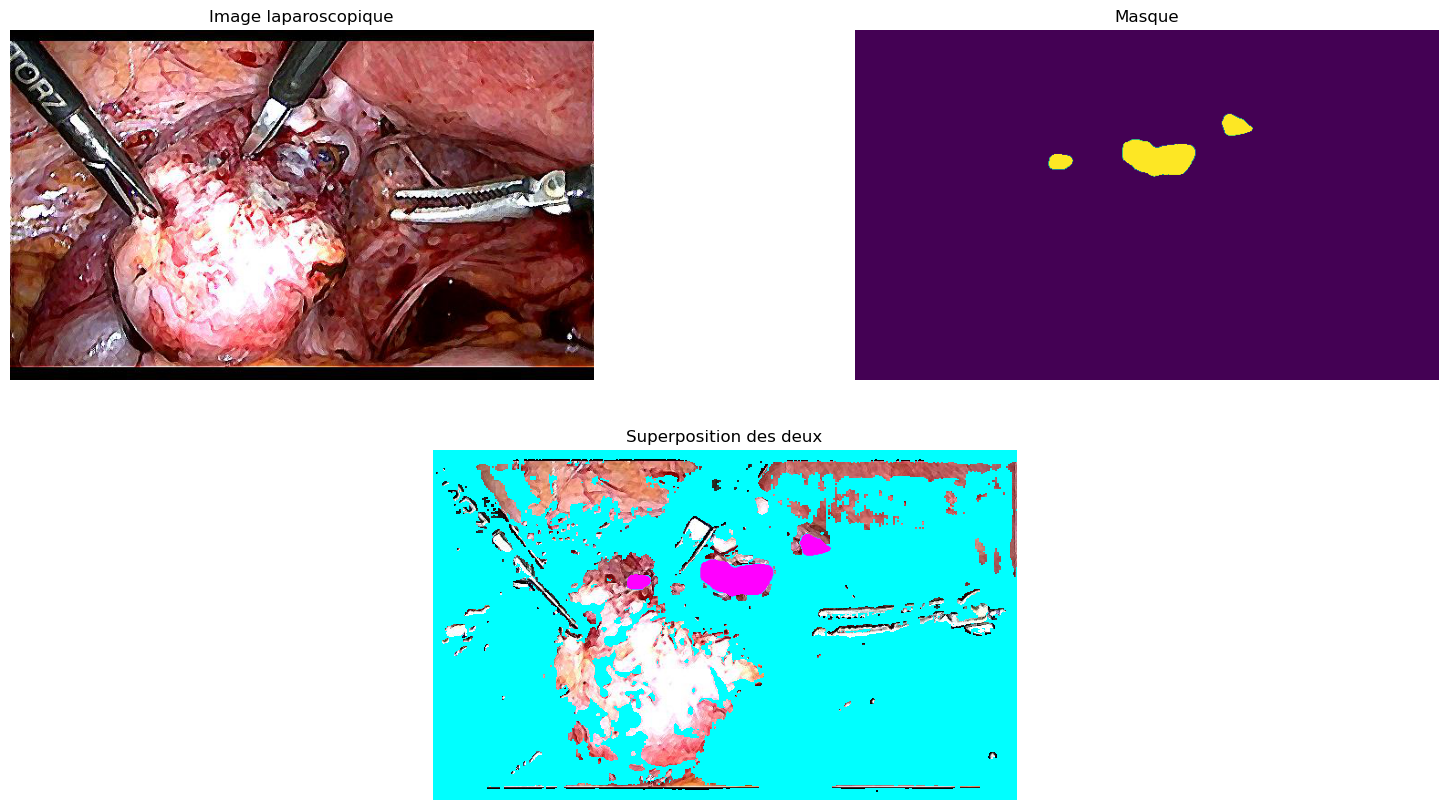

In [34]:
nb_files = len(filelist_img)

IOU_keras = MeanIoU(num_classes=2)

for i in range(2):
    img = utils.getImgPath(filelist_img[i])
    mask = utils.getMaskPath(filelist_mask[i])
    
    img = img / 255.
    img = np.expand_dims(img, 0)
    
    prediction = (model.predict(img))
    
    predicted_img=np.reshape(prediction, (384, 640, 1))

    disp.plot3(img[0], predicted_img)
    
#     predicted_arr = np.where(predicted_img<0.9, 0, 1)
    
#     IOU_keras.update_state(ground_truth, predicted_arr)
#     print("Mean IoU = ", IOU_keras.result().numpy())
#     disp.plot3(img_, predicted_arr)

# test_img_input=np.expand_dims(test_img, 0)
# print(test_img_input.shape)
# prediction = (model.predict(test_img_input))
# print(prediction.shape)
# predicted_img=np.reshape(prediction, (384, 640, 1))
# print(predicted_img.shape)

# plt.figure(figsize=(20, 15))
# plt.subplot(231)
# plt.title('Testing Image')
# plt.imshow(test_img)
# plt.axis('off')
# plt.subplot(232)
# plt.title('Testing Label')
# plt.imshow(ground_truth, cmap='cool')
# plt.axis('off')
# plt.subplot(233)
# plt.title('Prediction on test image')
# plt.imshow(predicted_img, cmap='cool')
# plt.axis('off')
# plt.show()

# disp.plot3(test_img, predicted_img)
